PillCam dataset split into neg/pos and trained using Resnet50 without augmentation.  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [4]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'resnet50',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['Normal'],
    "num_epochs": 100,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.001,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [5]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Negative class names:
        - Normal
Positive class names:
        - Anatomic landmarks
        - Unknown
        - Protruding lesions
        - Flat lesions
        - Lumen
        - Mucosa
        - Excavated lesions

Negative samples: 33129 | 74.26%
Positive samples: 11485 | 25.74%

Total number of images: 44614
Dataset.list_files:  /mnt/sdb/augere_export_class/*/*.*g 

[0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 1 0]
[0 0 0 0 1 0 1 1 0 0]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 1 1 1 0 0 1]
[1 1 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 1 1]

Full dataset sample size:        44614
Train dataset sample size:       31229
Test dataset sample size:         6692
Validation dataset sample size:   6693


# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [6]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [7]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [8]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=config["img_shape"])

res_net.trainable = True

In [9]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation='sigmoid',
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

### Callbacks

In [10]:
initial_learning_rate = learning_rate
decay_steps = train_steps
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

## Set correct initial bias


In [11]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(train_ds.take(1))[:10]

array([[0.13881117],
       [0.1468274 ],
       [0.14440289],
       [0.16905212],
       [0.14672026],
       [0.15479094],
       [0.1428304 ],
       [0.14410987],
       [0.15075105],
       [0.13968566]], dtype=float32)

In [12]:
results = bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6070


In [13]:
initial_bias = np.log([pos/neg])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: -1.0594


In [14]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(train_ds, verbose=0, steps=train_steps)

print ("Initial guess should be around:", pos/total)
new_bias_model.predict(train_ds.take(1))[:10]

Initial guess should be around: 0.2574304030125073


array([[0.824352  ],
       [0.8210994 ],
       [0.8135612 ],
       [0.809533  ],
       [0.8222644 ],
       [0.7966758 ],
       [0.8145866 ],
       [0.76933765],
       [0.8281247 ],
       [0.8181077 ]], dtype=float32)

In [15]:
results = new_bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3174


In [16]:
initial_weights = os.path.join(log_dir,'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

## Baseline

In [19]:
baseline_model = make_model()
baseline_model.load_weights(initial_weights)

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 243 steps, validate for 52 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
243/243 [==============================] - 210s 866ms/step - loss: 0.3719 - tp: 4479.0000 - fp: 772.0000 - tn: 22306.0000 - fn: 3547.0000 - accuracy: 0.8611 - precision: 0.8530 - recall: 0.5581 - auc: 0.8882 - val_loss: 0.6215 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4910.0000 - val_fn: 1746.0000 - val_accuracy: 0.7377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5334

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008259687287559483.
Epoch 2/100
243/243 [==============================] - 14s 59ms/step - loss: 0.1835 - tp: 6509.0000 - fp: 617.0000 - tn: 22477.0000 - fn: 1501.0000 - accuracy: 0.9319 - precision: 0.9134 - recall: 0.8126 - auc: 0.9683 - val_loss: 0.6171 - val_tp: 51.0000 - val_fp: 49.0000 - val_tn: 4860.0000 - val_fn: 1696.0000 - val_accuracy: 0.7378 - val_precision: 0.5100 - val_recall: 0.0292 - val_a

`Keras`
Save/load the model

In [17]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Some functions

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [21]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [22]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [23]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [24]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

### Validate the baseline model

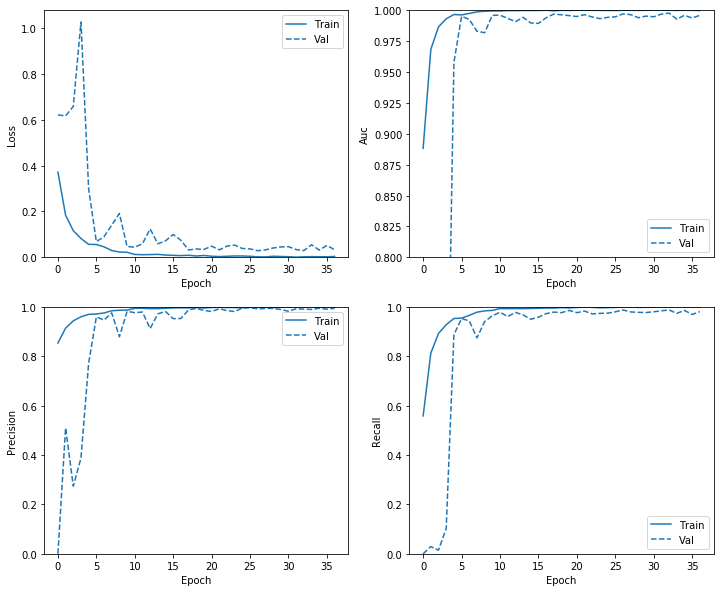

In [25]:
plot_metrics(baseline_history)
plt.savefig(log_dir+"/baseline_metrics_plot")

In [26]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

52/52 - 162s - loss: 0.0290 - tp: 1731.0000 - fp: 17.0000 - tn: 4882.0000 - fn: 26.0000 - accuracy: 0.9935 - precision: 0.9903 - recall: 0.9852 - auc: 0.9974

loss : 0.028991313409698287
tp : 1731.0
fp : 17.0
tn : 4882.0
fn : 26.0
accuracy : 0.9935396909713745
precision : 0.9902746081352234
recall : 0.9852020740509033
auc : 0.9973687529563904



In [27]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  3685
Legitimate Lesions Incorrectly Detected (False Positives):  12
Fraudulent Lesions Missed (False Negatives):  21
Fraudulent Lesions Detected (True Positives):  1282
Total Fraudulent Lesions:  1303



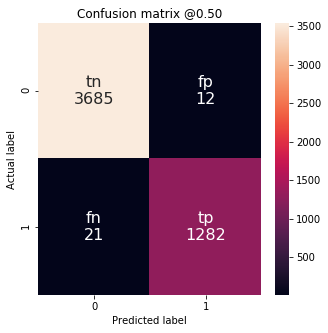

In [30]:
plot_cm(val_labels_baseline, val_predictions_baseline)
plt.savefig(log_dir+"/baseline_cm_plot")

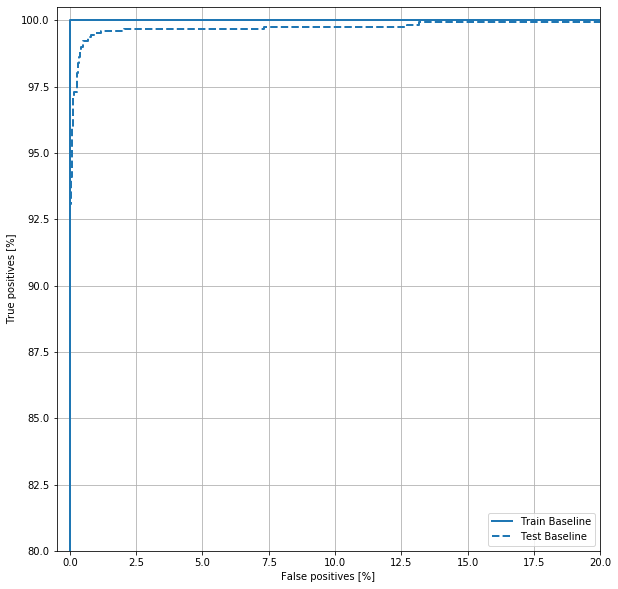

In [29]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/baseline_roc_plot")

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [31]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.94


In [32]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 243 steps, validate for 52 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
243/243 [==============================] - 24s 98ms/step - loss: 0.3601 - tp: 4630.0000 - fp: 815.0000 - tn: 22267.0000 - fn: 3392.0000 - accuracy: 0.8647 - precision: 0.8503 - recall: 0.5772 - auc: 0.8999 - val_loss: 0.5990 - val_tp: 1.0000 - val_fp: 9.0000 - val_tn: 4899.0000 - val_fn: 1747.0000 - val_accuracy: 0.7362 - val_precision: 0.1000 - val_recall: 5.7208e-04 - val_auc: 0.6218

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008259687287559483.
Epoch 2/100
243/243 [==============================] - 14s 59ms/step - loss: 0.1939 - tp: 6539.0000 - fp: 618.0000 - tn: 22457.0000 - fn: 1490.0000 - accuracy: 0.9322 - precision: 0.9137 - recall: 0.8144 - auc: 0.9686 - val_loss: 0.6031 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4910.0000 - val_fn: 1746.0000 - val_accuracy: 0.7377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_a

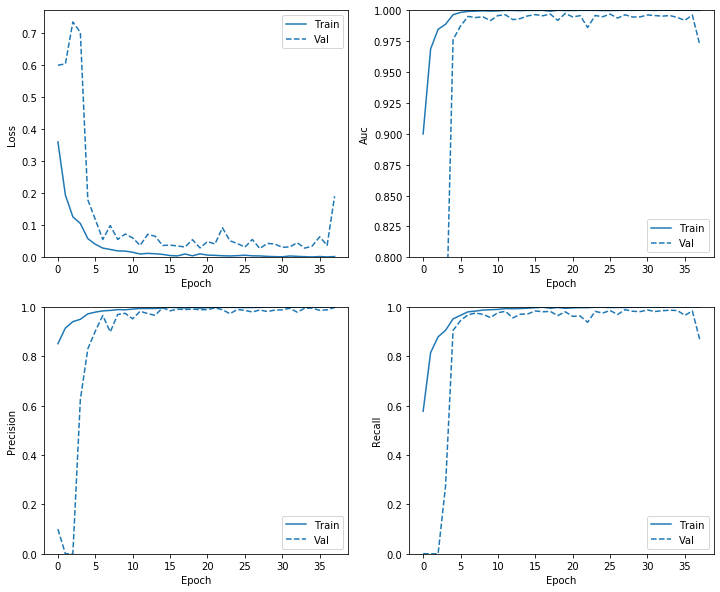

In [33]:
plot_metrics(weighted_history)
plt.savefig(log_dir+"/weighted_metrics_plot")

In [34]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/weighted_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

52/52 - 1s - loss: 0.0333 - tp: 1735.0000 - fp: 17.0000 - tn: 4878.0000 - fn: 26.0000 - accuracy: 0.9935 - precision: 0.9903 - recall: 0.9852 - auc: 0.9953

loss : 0.033298373223750295
tp : 1735.0
fp : 17.0
tn : 4878.0
fn : 26.0
accuracy : 0.9935396909713745
precision : 0.9902967810630798
recall : 0.9852356910705566
auc : 0.9953393340110779



In [35]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  3701
Legitimate Lesions Incorrectly Detected (False Positives):  13
Fraudulent Lesions Missed (False Negatives):  18
Fraudulent Lesions Detected (True Positives):  1268
Total Fraudulent Lesions:  1286



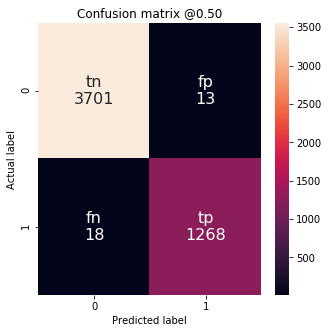

In [36]:
plot_cm(val_labels_weighted, val_predictions_weighted)
plt.savefig(log_dir+"/weighted_cm_plot")

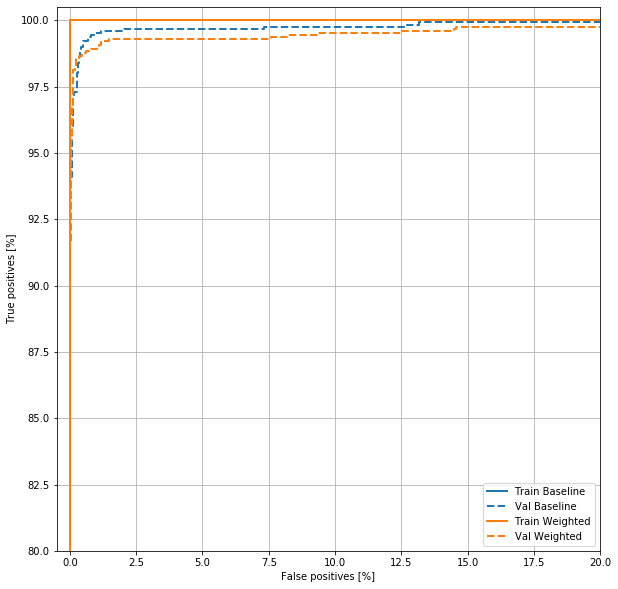

In [37]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/weighted_roc_plot")

## Oversampling the minority class

In [141]:
# Remove the cache
!rm -rf ./cache/*

# Set dataset resample to true to make 5050 distribution of samples
config["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [142]:
train_ds_resampled, test_ds_resampled, val_ds_resampled, params = create_dataset(config)


Negative                    : 33129 | 74.26%
---------------------------------------------
     - Normal               : 33129 | 74.26%

Positive                    : 11485 | 25.74%
---------------------------------------------
     - Anatomic landmarks   :  6868 | 15.39%
     - Unknown              :   177 | 0.40%
     - Protruding lesions   :   583 | 1.31%
     - Flat lesions         :   908 | 2.04%
     - Lumen                :  1446 | 3.24%
     - Mucosa               :   251 | 0.56%
     - Excavated lesions    :  1252 | 2.81%

Total number of image       : 44614

Dataset.list_files:  /mnt/sdb/augere_export_class/*/*.*g 

[0 0 0 0 0 0 1 0 1 0]
[0 1 0 0 1 1 0 1 0 0]
[0 0 0 0 1 0 1 0 0 0]
[0 0 0 1 0 0 0 0 0 1]
[0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 0 1]
[0 0 0 0 1 1 0 0 0 0]
[0 0 1 0 0 1 0 1 0 0]
[1 0 1 1 0 0 0 0 1 0]
[1 1 0 0 0 1 1 1 0 1]

Resamplng the dataset..

Fractions:  [0.7341797  0.26582032]
Counts:  [7518. 2722.]

[0 1 0 0 1 1 1 0 1 0]
[0 0 1 1 0 0 0 1 1 0]
[1 1 1 1 1 1 1 

In [40]:
# Check the mean value is close to 0.5
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.4921875
0.5
0.484375


In [41]:
resampled_steps_per_epoch = np.ceil(2.0*neg/config["batch_size"])
print (resampled_steps_per_epoch)

518.0


In [51]:
resampled_steps_per_epoch = 200

In [42]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = resampled_steps_per_epoch,
    epochs = config["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = resampled_steps_per_epoch,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 518.0 steps, validate for 518.0 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
518/518 [==============================] - 274s 530ms/step - loss: 0.2780 - tp: 28080.0000 - fp: 2369.0000 - tn: 30731.0000 - fn: 5124.0000 - accuracy: 0.8870 - precision: 0.9222 - recall: 0.8457 - auc: 0.9576 - val_loss: 2.7786 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 33628.0000 - val_fn: 32676.0000 - val_accuracy: 0.5072 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5456

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008259687287559483.
Epoch 2/100
518/518 [==============================] - 37s 71ms/step - loss: 0.0906 - tp: 31933.0000 - fp: 933.0000 - tn: 32179.0000 - fn: 1259.0000 - accuracy: 0.9669 - precision: 0.9716 - recall: 0.9621 - auc: 0.9942 - val_loss: 1.3337 - val_tp: 14524.0000 - val_fp: 4931.0000 - val_tn: 28708.0000 - val_fn: 18141.0000 - val_accuracy: 0.6520 - val_precision: 0.7465 - val_recal

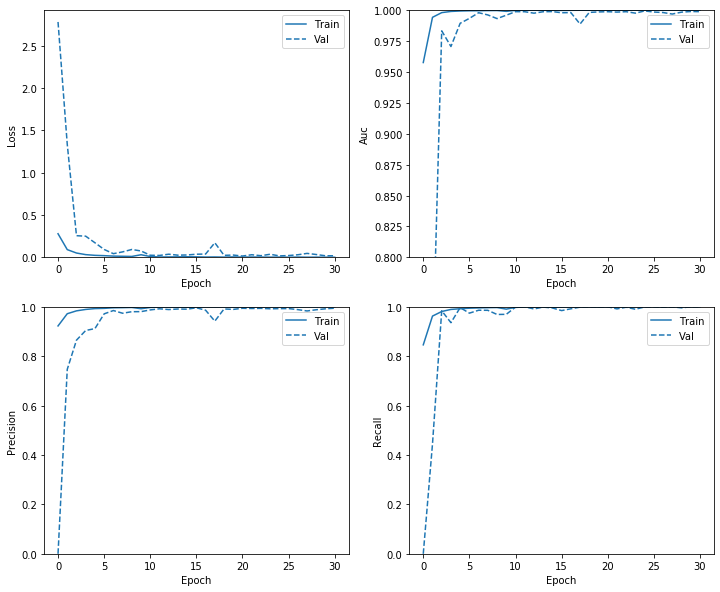

In [43]:
plot_metrics(resampled_history)
plt.savefig(log_dir+"/resampled_metrics_plot")

In [44]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/resampled_val_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

52/52 - 159s - loss: 0.0174 - tp: 3322.0000 - fp: 26.0000 - tn: 3307.0000 - fn: 1.0000 - accuracy: 0.9959 - precision: 0.9922 - recall: 0.9997 - auc: 0.9991

loss : 0.01741766741081217
tp : 3322.0
fp : 26.0
tn : 3307.0
fn : 1.0
accuracy : 0.9959434866905212
precision : 0.9922341704368591
recall : 0.999699056148529
auc : 0.9990621209144592



In [45]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds_resampled, resampled_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  2475
Legitimate Lesions Incorrectly Detected (False Positives):  19
Fraudulent Lesions Missed (False Negatives):  1
Fraudulent Lesions Detected (True Positives):  2505
Total Fraudulent Lesions:  2506



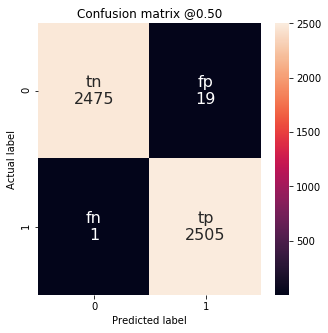

In [46]:
plot_cm(val_labels_resampled, val_predictions_resampled)
plt.savefig(log_dir+"/resampled_cm_plot")

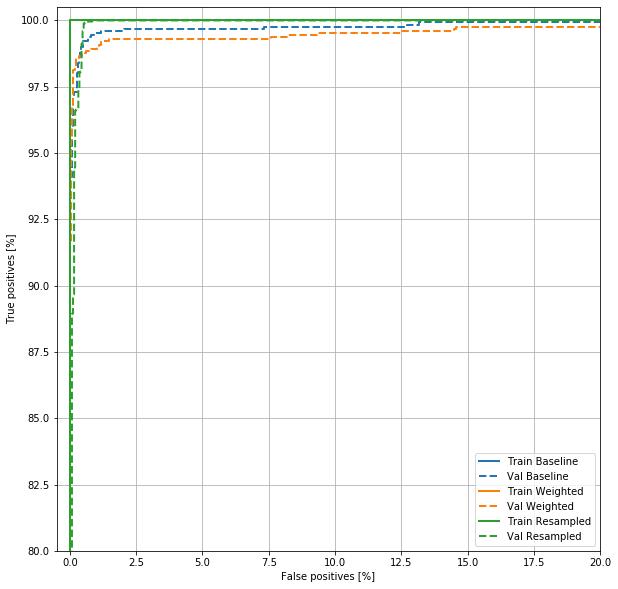

In [47]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/resampled_roc_plot")

`Tensorboard`

## Predict new samples

In [48]:
# Fetch one batch
images, labels = next(iter(val_ds_resampled))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

Label:          1 | Positive
Prediction: 1.000 | Positive
Image:         41 | 128


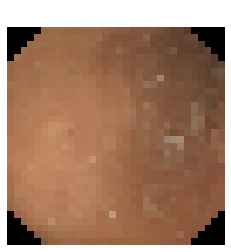

In [94]:
class_names = params["class_names"]
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
# rand = 79
image = images[rand]
label = labels[rand]

# Predict one image
prediction = resampled_model.predict(np.expand_dims(image, axis=0))[0][0]
pred_lab = int(np.round(prediction))

print ("Label: {:>10} | {}".format(label, params["class_names"][label]))
print ("Prediction: {:0.3f} | {}".format(prediction, class_names[pred_lab]))
print ("Image: {:>10} | {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(class_names[pred_lab], fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [50]:
# Predict one batch
predictions = resampled_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  1.000  1.000
  2  0.000  0.000
  3  0.000  0.000
  4  1.000  1.000
  5  1.000  1.000
  6  0.000  0.000
  7  0.000  0.000
  8  0.000  0.000
  9  0.000  0.000
 10  0.000  0.000
 11  0.000  0.000
 12  1.000  1.000
 13  1.000  1.000
 14  1.000  1.000
 15  1.000  1.000
 16  0.000  0.000
 17  1.000  1.000
 18  0.000  0.000
 19  0.000  0.000
 20  1.000  1.000
 21  0.000  0.000
 22  1.000  1.000
 23  1.000  1.000
 24  0.000  0.000
 25  0.000  0.000
 26  0.000  0.000
 27  1.000  1.000
 28  1.000  1.000
 29  0.000  0.000
 30  0.000  0.000
 31  1.000  1.000
 32  1.000  1.000
 33  0.000  0.000
 34  0.000  0.000
 35  0.000  0.000
 36  0.000  0.000
 37  0.000  0.000
 38  0.000  0.000
 39  1.000  1.000
 40  0.000  0.000
 41  1.000  1.000
 42  1.000  1.000
 43  0.000  0.000
 44  0.000  0.000
 45  0.000  0.000
 46  1.000  1.000
 47  1.000  1.000
 48  0.000  0.000
 49  1.000  1.000
 50  0.000  0.000
 51  1.000  1.000
 52  1.000  1.000
 53  0.000 